In [1]:
from tqdm import tqdm
import numpy as np
import json
import pandas as pd
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from io import StringIO
import matplotlib.pyplot as plt
from scipy.stats import norm
from datasets import load_dataset
import emoji
import re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.inspection import permutation_importance
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelBinarizer

SPACY_EN_MODEL = spacy.load("en_core_web_sm")
TORCH_DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

class categoryNN(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_classes):
        super(categoryNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_classes)
        self.relu = nn.ReLU()

        # Attention Mechanism (Learnable Mask)
        self.attention_weights = nn.Parameter(torch.ones(input_dim))  # Initialized to 1

    def forward(self, x):
        # Apply learnable attention weights to the input
        x = x * self.attention_weights

        # Pass through the network
        x = self.relu(self.fc1(x))  
        x = self.relu(self.fc2(x))  
        x = self.fc3(x)             
        return x

# https://universaldependencies.org/u/pos/
# https://universaldependencies.org/u/dep/
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# https://academic.oup.com/bioinformatics/article/26/10/1340/193348
# https://link.springer.com/article/10.1023/A:1012487302797
# https://aclanthology.org/W14-5902.pdf

### Initial Data Preparation

In [2]:
categories = ['All_Beauty','Amazon_Fashion','Appliances','Baby_Products',
              'Grocery_and_Gourmet_Food','Arts_Crafts_and_Sewing','Office_Products',
              'Pet_Supplies','Industrial_and_Scientific','Tools_and_Home_Improvement']


dfs = []
for cat in categories:
    print(cat)
    raw = load_dataset("McAuley-Lab/Amazon-Reviews-2023",f"raw_review_{cat}", trust_remote_code=True)
    df = raw['full'].to_pandas()
    df = df[(df['rating'].isin([4., 5., 1., 2., 3.])) & (df['helpful_vote']>0)]
    sample = df.groupby('rating').sample(100)[['rating','title','text','parent_asin']]
    sample['category'] = cat
    dfs.append(sample)

pd.concat(dfs,ignore_index=True).to_csv('project_dataset.csv')

### Preprocessing Functions

In [3]:

def preprocess_text(texts,custom_pos_filter=[],pos_tagging=False,remove_stop=False):
    nlp_model = SPACY_EN_MODEL
    texts = [text.replace('<br />', ' ') for text in texts]
    processed_docs = []
    for doc in tqdm(nlp_model.pipe(texts, batch_size=100), total=len(texts), desc="Processing texts"):
        new_doc = []
        for token in doc:
            if not token.dep_ in ['case'] and not token.is_punct and not token.like_num:
                if not token.pos_ in ['DET','PRON','CCONJ', 'SCONJ','AUX','X','SYM','PUNCT','SPACE']:
                    if custom_pos_filter:
                        if token.pos_ not in custom_pos_filter:
                            continue
                    if remove_stop:
                        if token.is_stop:
                            continue
                    if not emoji.is_emoji(token):
                        if pos_tagging:
                            new_doc.append('['+token.pos_+']'+token.lemma_.lower())
                        else:
                            new_doc.append(token.lemma_.lower())
                    # else:
                    #     new_doc.append(token.lemma_.lower().encode('utf-8').hex())
        new_doc = [t for t in new_doc if t.strip() not in ['',"’s","’re","’","’m","’re"]]
        processed_docs.append(new_doc)

    return processed_docs

def transform_data(data,min_df=0.005,ngram_range=(1,1)):
    # if min_df:
    count_vectorizer = CountVectorizer(min_df=min_df,tokenizer=lambda x: x, preprocessor=lambda x: x,ngram_range=ngram_range)
    # else:
    #     count_vectorizer = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x,ngram_range=ngram_range)
    count_matrix = count_vectorizer.fit_transform(data)
    vocabulary = count_vectorizer.get_feature_names_out()

    tfidf_transformer = TfidfTransformer()
    train_tfidf_transformed = tfidf_transformer.fit_transform(count_matrix.toarray())
    train_tfidf_matrix = train_tfidf_transformed.toarray()

    return train_tfidf_matrix,tfidf_transformer,count_vectorizer,vocabulary


df_reviews = pd.read_csv('project_dataset.csv',index_col=0)
df_reviews['pos_neg'] = df_reviews['rating'].map({1.0:'neg',2.0:'neg',3.0:'neutral',4.0:'pos',5.0:'pos'})
df_pos_neg = df_reviews.query("`pos_neg`!='neutral'")

### Setiment Model
##### SVM Non-POS

In [4]:
preprocessed_text_sent_non_pos = preprocess_text(df_pos_neg['title']+' '+df_pos_neg['text'],custom_pos_filter=[],pos_tagging=False,remove_stop=False)
X = preprocessed_text_sent_non_pos
y = df_pos_neg['pos_neg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train_transform,tfidf_transformer_sent_non_pos,count_vectorizer_sent_non_pos,vocabulary_sent_non_pos = transform_data(X_train,min_df=5,ngram_range=(1,4))
X_test_transform = tfidf_transformer_sent_non_pos.transform(count_vectorizer_sent_non_pos.transform(X_test).toarray()).toarray()

scaler = StandardScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

print('Features: ', len(vocabulary_sent_non_pos))

svc_model_base_sentiment_non_pos = SVC(random_state=42,**{'C': 1.0, 'kernel': 'linear'})
svc_model_base_sentiment_non_pos.fit(X_train_transform_scaled, y_train.values)

# Make predictions
y_pred = svc_model_base_sentiment_non_pos.predict(X_test_transform_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Processing texts: 100%|██████████| 4000/4000 [00:14<00:00, 268.33it/s]
/Users/shivpalit/Desktop/JHU/shiv_jhu_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Features:  5279
Accuracy: 0.775
Classification Report:
               precision    recall  f1-score   support

         neg       0.78      0.76      0.77       400
         pos       0.77      0.79      0.78       400

    accuracy                           0.78       800
   macro avg       0.78      0.77      0.77       800
weighted avg       0.78      0.78      0.77       800



In [5]:
X_train_counts = count_vectorizer_sent_non_pos.transform(X_train).toarray()
chi2_scores, _ = chi2(X_train_counts, y_train)
print('Top 10 Features: ',vocabulary_sent_non_pos[np.argsort(chi2_scores)[-10:][::-1]])

chi_thresh = 10
top_features_sent_non_pos = [int(i) for i in set(np.where(chi2_scores>chi_thresh)[0])]

Top 10 Features:  ['great' 'not' 'love' 'return' 'good' 'easy' 'waste' 'perfect' 'not buy'
 'easy to']


In [6]:
X_train_transform_scaled_top = X_train_transform_scaled[:,top_features_sent_non_pos]
X_test_transform_scaled_top = X_test_transform_scaled[:,top_features_sent_non_pos]

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear','rbf']}
grid_search = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_transform_scaled_top, y_train)
print("Best Parameters:", grid_search.best_params_, grid_search.best_score_)


svc_model_sent_non_pos = SVC(random_state=42,**grid_search.best_params_)
svc_model_sent_non_pos.fit(X_train_transform_scaled_top, y_train)

# Make predictions
y_pred = svc_model_sent_non_pos.predict(X_test_transform_scaled_top)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'C': 1, 'kernel': 'rbf'} 0.8521875
Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

         neg       0.79      0.84      0.82       400
         pos       0.83      0.78      0.81       400

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



##### NN Non-POS

In [7]:
y_cat = df_pos_neg['pos_neg'].astype('category').cat.codes.values
y_map = dict(enumerate(df_pos_neg['pos_neg'].astype('category').cat.categories))

X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42,stratify=y)

X_train_transform = tfidf_transformer_sent_non_pos.transform(count_vectorizer_sent_non_pos.transform(X_train).toarray()).toarray()
X_test_transform = tfidf_transformer_sent_non_pos.transform(count_vectorizer_sent_non_pos.transform(X_test).toarray()).toarray()

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

X_train_transform_scaled, X_val_transform_scaled, y_train, y_val = train_test_split(X_train_transform_scaled, y_train, test_size=0.2, random_state=42,stratify=y_train)

# Split into train, validation, and test sets
train_X, val_X, test_X = X_train_transform_scaled[:,top_features_sent_non_pos], X_val_transform_scaled[:,top_features_sent_non_pos], X_test_transform_scaled[:,top_features_sent_non_pos]
train_y, val_y, test_y = y_train, y_val, y_test

batch_size = 8

train_loader = DataLoader(
    TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.long)),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.long)),
    batch_size=batch_size
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.long)),
    batch_size=batch_size
)

input_dim = train_X.shape[1]
hidden_dim1 = int(np.power(2,np.floor(np.log2(input_dim//4))))
hidden_dim2 = int(np.power(2,np.floor(np.log2(hidden_dim1//4))))
num_classes = len(y_map)

print('Inputs:',input_dim)
print('Hidden1:',hidden_dim1)
print('Hidden2:',hidden_dim2)
print('Out:',num_classes)
print()

nn_model_sent_non_pos = categoryNN(input_dim, hidden_dim1, hidden_dim2, num_classes).to(TORCH_DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model_sent_non_pos.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=1e-6
)

# Training loop with early stopping
num_epochs = 500
patience = 50
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    nn_model_sent_non_pos.train()
    train_loss = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)

        optimizer.zero_grad()
        outputs = nn_model_sent_non_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    nn_model_sent_non_pos.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to the selected device
            inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
            outputs = nn_model_sent_non_pos(inputs)  # No external mask needed
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Learning rate decay
    scheduler.step()

    if epoch % 10 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(nn_model_sent_non_pos.state_dict(), "models/best_nn_model_sent_non_pos.pth")  # Save the best nn_model_sent_non_pos
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best nn_model_sent_non_pos and test
nn_model_sent_non_pos.load_state_dict(torch.load("models/best_nn_model_sent_non_pos.pth"))
nn_model_sent_non_pos.eval()

# Test phase
test_loss = 0
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
        outputs = nn_model_sent_non_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.detach().cpu().numpy().tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())
        total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_true =  np.array([y_map[i] for i in y_true])
y_pred =  np.array([y_map[i] for i in y_pred])

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Inputs: 271
Hidden1: 64
Hidden2: 16
Out: 2

Epoch 1/500, Train Loss: 0.7019, Val Loss: 0.7014
Epoch 11/500, Train Loss: 0.6946, Val Loss: 0.6948
Epoch 21/500, Train Loss: 0.6855, Val Loss: 0.6849
Epoch 31/500, Train Loss: 0.6710, Val Loss: 0.6716
Epoch 41/500, Train Loss: 0.6507, Val Loss: 0.6497
Epoch 51/500, Train Loss: 0.6230, Val Loss: 0.6247
Epoch 61/500, Train Loss: 0.5901, Val Loss: 0.5891
Epoch 71/500, Train Loss: 0.5486, Val Loss: 0.5513
Epoch 81/500, Train Loss: 0.5090, Val Loss: 0.5086
Epoch 91/500, Train Loss: 0.4696, Val Loss: 0.4728
Epoch 101/500, Train Loss: 0.4350, Val Loss: 0.4354
Epoch 111/500, Train Loss: 0.4046, Val Loss: 0.4080
Epoch 121/500, Train Loss: 0.3812, Val Loss: 0.3827
Epoch 131/500, Train Loss: 0.3625, Val Loss: 0.3660
Epoch 141/500, Train Loss: 0.3483, Val Loss: 0.3510
Epoch 151/500, Train Loss: 0.3367, Val Loss: 0.3412
Epoch 161/500, Train Loss: 0.3280, Val Loss: 0.3324
Epoch 171/500, Train Loss: 0.3204, Val Loss: 0.3266
Epoch 181/500, Train Loss: 0.31

/var/folders/94/9p3trp7s00xgwdwpw163015r0000gn/T/ipykernel_962/542511552.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model_sent_non_pos.load_state_dict(torch.lo

##### SVM POS

In [8]:
preprocessed_text_sent_pos = preprocess_text(df_pos_neg['title']+' '+df_pos_neg['text'],custom_pos_filter=[],pos_tagging=True,remove_stop=False)
X = preprocessed_text_sent_pos
y = df_pos_neg['pos_neg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train_transform,tfidf_transformer_sent_pos,count_vectorizer_sent_pos,vocabulary_sent_pos = transform_data(X_train,min_df=5,ngram_range=(1,4))
X_test_transform = tfidf_transformer_sent_pos.transform(count_vectorizer_sent_pos.transform(X_test).toarray()).toarray()

scaler = StandardScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

print('Features: ', len(vocabulary_sent_pos))

svc_model_base_sentiment_pos = SVC(random_state=42,**{'C': 1.0, 'kernel': 'linear'})
svc_model_base_sentiment_pos.fit(X_train_transform_scaled, y_train.values)

# Make predictions
y_pred = svc_model_base_sentiment_pos.predict(X_test_transform_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Processing texts:   0%|          | 0/4000 [00:00<?, ?it/s]

Processing texts: 100%|██████████| 4000/4000 [00:14<00:00, 283.56it/s]
/Users/shivpalit/Desktop/JHU/shiv_jhu_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Features:  5263
Accuracy: 0.74
Classification Report:
               precision    recall  f1-score   support

         neg       0.75      0.73      0.74       400
         pos       0.73      0.75      0.74       400

    accuracy                           0.74       800
   macro avg       0.74      0.74      0.74       800
weighted avg       0.74      0.74      0.74       800



In [9]:
X_train_counts = count_vectorizer_sent_pos.transform(X_train).toarray()
chi2_scores, _ = chi2(X_train_counts, y_train)
print('Top 10 Features: ',vocabulary_sent_pos[np.argsort(chi2_scores)[-10:][::-1]])

chi_thresh = 10
top_features_sent_pos = [int(i) for i in set(np.where(chi2_scores>chi_thresh)[0])]

Top 10 Features:  ['[PART]not' '[ADJ]great' '[VERB]love' '[ADJ]good' '[VERB]return'
 '[ADJ]easy' '[PART]not [VERB]buy' '[ADP]for' '[ADJ]easy [PART]to'
 '[ADJ]disappointed']


In [10]:
X_train_transform_scaled_top = X_train_transform_scaled[:,top_features_sent_pos]
X_test_transform_scaled_top = X_test_transform_scaled[:,top_features_sent_pos]

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear','rbf']}
grid_search = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_transform_scaled_top, y_train)
print("Best Parameters:", grid_search.best_params_, grid_search.best_score_)


svc_model_sent_pos = SVC(random_state=42,**grid_search.best_params_)
svc_model_sent_pos.fit(X_train_transform_scaled_top, y_train)

# Make predictions
y_pred = svc_model_sent_pos.predict(X_test_transform_scaled_top)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'C': 1, 'kernel': 'rbf'} 0.8603125
Accuracy: 0.8125
Classification Report:
               precision    recall  f1-score   support

         neg       0.80      0.83      0.82       400
         pos       0.83      0.79      0.81       400

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



##### NN POS

In [11]:
y = df_pos_neg['pos_neg'].astype('category').cat.codes.values
y_map = dict(enumerate(df_pos_neg['pos_neg'].astype('category').cat.categories))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)


X_train_transform = tfidf_transformer_sent_pos.transform(count_vectorizer_sent_pos.transform(X_train).toarray()).toarray()
X_test_transform = tfidf_transformer_sent_pos.transform(count_vectorizer_sent_pos.transform(X_test).toarray()).toarray()

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

X_train_transform_scaled, X_val_transform_scaled, y_train, y_val = train_test_split(X_train_transform_scaled, y_train, test_size=0.2, random_state=42,stratify=y_train)

# Split into train, validation, and test sets
train_X, val_X, test_X = X_train_transform_scaled[:,top_features_sent_pos], X_val_transform_scaled[:,top_features_sent_pos], X_test_transform_scaled[:,top_features_sent_pos]
train_y, val_y, test_y = y_train, y_val, y_test

batch_size = 8

train_loader = DataLoader(
    TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.long)),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.long)),
    batch_size=batch_size
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.long)),
    batch_size=batch_size
)

input_dim = train_X.shape[1]
hidden_dim1 = int(np.power(2,np.floor(np.log2(input_dim//4))))
hidden_dim2 = int(np.power(2,np.floor(np.log2(hidden_dim1//4))))
num_classes = len(y_map)

print('Inputs:',input_dim)
print('Hidden1:',hidden_dim1)
print('Hidden2:',hidden_dim2)
print('Out:',num_classes)
print()

nn_model_sent_pos = categoryNN(input_dim, hidden_dim1, hidden_dim2, num_classes).to(TORCH_DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model_sent_pos.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=1e-6
)

# Training loop with early stopping
num_epochs = 500
patience = 50
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    nn_model_sent_pos.train()
    train_loss = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)

        optimizer.zero_grad()
        outputs = nn_model_sent_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    nn_model_sent_pos.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to the selected device
            inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
            outputs = nn_model_sent_pos(inputs)  # No external mask needed
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Learning rate decay
    scheduler.step()

    if epoch % 10 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(nn_model_sent_pos.state_dict(), "models/best_nn_model_sent_pos.pth")  # Save the best nn_model_sent_pos
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best nn_model_sent_pos and test
nn_model_sent_pos.load_state_dict(torch.load("models/best_nn_model_sent_pos.pth"))
nn_model_sent_pos.eval()

# Test phase
test_loss = 0
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
        outputs = nn_model_sent_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.detach().cpu().numpy().tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())
        total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_true =  np.array([y_map[i] for i in y_true])
y_pred =  np.array([y_map[i] for i in y_pred])

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Inputs: 269
Hidden1: 64
Hidden2: 16
Out: 2

Epoch 1/500, Train Loss: 0.6999, Val Loss: 0.6994
Epoch 11/500, Train Loss: 0.6956, Val Loss: 0.6956
Epoch 21/500, Train Loss: 0.6899, Val Loss: 0.6895
Epoch 31/500, Train Loss: 0.6797, Val Loss: 0.6801
Epoch 41/500, Train Loss: 0.6638, Val Loss: 0.6630
Epoch 51/500, Train Loss: 0.6375, Val Loss: 0.6391
Epoch 61/500, Train Loss: 0.6042, Val Loss: 0.6034
Epoch 71/500, Train Loss: 0.5637, Val Loss: 0.5671
Epoch 81/500, Train Loss: 0.5229, Val Loss: 0.5238
Epoch 91/500, Train Loss: 0.4828, Val Loss: 0.4882
Epoch 101/500, Train Loss: 0.4479, Val Loss: 0.4516
Epoch 111/500, Train Loss: 0.4173, Val Loss: 0.4249
Epoch 121/500, Train Loss: 0.3924, Val Loss: 0.3992
Epoch 131/500, Train Loss: 0.3719, Val Loss: 0.3819
Epoch 141/500, Train Loss: 0.3557, Val Loss: 0.3657
Epoch 151/500, Train Loss: 0.3424, Val Loss: 0.3550
Epoch 161/500, Train Loss: 0.3321, Val Loss: 0.3452
Epoch 171/500, Train Loss: 0.3230, Val Loss: 0.3385
Epoch 181/500, Train Loss: 0.31

/var/folders/94/9p3trp7s00xgwdwpw163015r0000gn/T/ipykernel_962/595118649.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model_sent_pos.load_state_dict(torch.load("

### Category Model

##### SVM Non-POS

In [12]:
preprocessed_texts_cat_non_pos = preprocess_text(df_reviews['title']+' '+df_reviews['text'],custom_pos_filter=[],pos_tagging=False, remove_stop=False)
X = preprocessed_texts_cat_non_pos
y = df_reviews['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train_transform,tfidf_transformer_cat_non_pos,count_vectorizer_cat_non_pos,vocabulary_cat_non_pos = transform_data(X_train,min_df=5,ngram_range=(1,4))
X_test_transform = tfidf_transformer_cat_non_pos.transform(count_vectorizer_cat_non_pos.transform(X_test).toarray()).toarray()

scaler = StandardScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

print('Features: ', len(vocabulary_cat_non_pos))

svc_model_base_category_non_pos = SVC(random_state=42,**{'C': 1.0, 'kernel': 'linear'})
svc_model_base_category_non_pos.fit(X_train_transform_scaled, y_train.values)

# Make predictions
y_pred = svc_model_base_category_non_pos.predict(X_test_transform_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Processing texts: 100%|██████████| 5000/5000 [00:18<00:00, 277.07it/s]
/Users/shivpalit/Desktop/JHU/shiv_jhu_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Features:  6644
Accuracy: 0.43
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.29      0.26      0.27       100
            Amazon_Fashion       0.59      0.57      0.58       100
                Appliances       0.61      0.56      0.58       100
    Arts_Crafts_and_Sewing       0.22      0.41      0.29       100
             Baby_Products       0.40      0.47      0.43       100
  Grocery_and_Gourmet_Food       0.74      0.60      0.66       100
 Industrial_and_Scientific       0.23      0.22      0.22       100
           Office_Products       0.49      0.44      0.47       100
              Pet_Supplies       0.64      0.49      0.55       100
Tools_and_Home_Improvement       0.37      0.28      0.32       100

                  accuracy                           0.43      1000
                 macro avg       0.46      0.43      0.44      1000
              weighted avg       0.46      0.43      0.44  

In [13]:
X_train_counts = count_vectorizer_cat_non_pos.transform(X_train).toarray()

lb = LabelBinarizer()
y_binary = lb.fit_transform(y_train)

feature_scores = []
for i, class_label in enumerate(lb.classes_):
    y_class = y_binary[:, i]
    chi2_scores, _ = chi2(X_train_counts, y_class)
    feature_scores.append(chi2_scores)

top_features_cat_non_pos = []
feature_scores = np.array(feature_scores)
for i in range(len(lb.classes_)):
    print(lb.classes_[i],':',vocabulary_cat_non_pos[np.argsort(feature_scores[i,:])[-10:][::-1]])

chi_thresh = 25
chi_classes = np.where(feature_scores > chi_thresh)[0]
unique_rows, counts = np.unique(chi_classes, return_counts=True)

print()
print('Chi2>5:')
for row, count in zip(unique_rows, counts):
    print(f"  -{lb.classes_[row]}: {count} Features")

top_features_cat_non_pos = [int(i) for i in set(np.where(feature_scores>chi_thresh)[1])]
print()
print('Final Features:',len(top_features_cat_non_pos))

All_Beauty : ['hair' 'skin' 'wig' 'shave' 'scent' 'brush' 'nail' 'shaver' 'face'
 'eyebrow']
Amazon_Fashion : ['dress' 'wear' 'shirt' 'fit' 'bra' 'chain' 'waist' 'outfit' 'size' 'to']
Appliances : ['filter' 'coffee' 'ice' 'water' 'fridge' 'dryer' 'refrigerator' 'part'
 'stove' 'cup']
Arts_Crafts_and_Sewing : ['yarn' 'project' 'paint' 'bead' 'sewing' 'needle' 'color' 'mold' 'paper'
 'backing']
Baby_Products : ['baby' 'diaper' 'stroller' 'seat' 'pillow' 'son' 'wipe' 'monitor'
 'diaper bag' 'strap']
Grocery_and_Gourmet_Food : ['taste' 'flavor' 'tea' 'delicious' 'chocolate' 'sugar' 'sweet'
 'taste like' 'stale' 'tasty']
Industrial_and_Scientific : ['filament' 'nozzle' 'carpet' 'cleaner' 'unit' 'vacuum' 'test' 'pipe'
 'print' '3d']
Office_Products : ['printer' 'pen' 'ink' 'cartridge' 'page' 'pencil' 'phone' 'print' 'label'
 'scan']
Pet_Supplies : ['dog' 'cat' 'litter' 'food' 'pet' 'tank' 'dog love' 'collar' 'chew'
 'cat not']
Tools_and_Home_Improvement : ['light' 'bulb' 'faucet' 'bright' 'l

In [14]:
X_train_transform_scaled_top = X_train_transform_scaled[:,top_features_cat_non_pos]
X_test_transform_scaled_top = X_test_transform_scaled[:,top_features_cat_non_pos]

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear','rbf']}
grid_search = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_transform_scaled_top, y_train)
print("Best Parameters:", grid_search.best_params_, grid_search.best_score_)


svc_model_cat_non_pos = SVC(random_state=42,**grid_search.best_params_)
svc_model_cat_non_pos.fit(X_train_transform_scaled_top, y_train)

# Make predictions
y_pred = svc_model_cat_non_pos.predict(X_test_transform_scaled_top)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'C': 1, 'kernel': 'rbf'} 0.51925
Accuracy: 0.52
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.49      0.50      0.49       100
            Amazon_Fashion       0.66      0.65      0.65       100
                Appliances       0.51      0.63      0.57       100
    Arts_Crafts_and_Sewing       0.31      0.56      0.40       100
             Baby_Products       0.60      0.55      0.58       100
  Grocery_and_Gourmet_Food       0.86      0.62      0.72       100
 Industrial_and_Scientific       0.27      0.34      0.30       100
           Office_Products       0.68      0.47      0.56       100
              Pet_Supplies       0.86      0.54      0.66       100
Tools_and_Home_Improvement       0.47      0.34      0.40       100

                  accuracy                           0.52      1000
                 macro avg       0.57      0.52      0.53      1000
              weighted a

#### NN Non-POS

In [15]:
y = df_reviews['category'].astype('category').cat.codes.values
y_map = dict(enumerate(df_pos_neg['category'].astype('category').cat.categories))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train_transform = tfidf_transformer_cat_non_pos.transform(count_vectorizer_cat_non_pos.transform(X_train).toarray()).toarray()
X_test_transform = tfidf_transformer_cat_non_pos.transform(count_vectorizer_cat_non_pos.transform(X_test).toarray()).toarray()

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

X_train_transform_scaled, X_val_transform_scaled, y_train, y_val = train_test_split(X_train_transform_scaled, y_train, test_size=0.2, random_state=42,stratify=y_train)

# Split into train, validation, and test sets
train_X, val_X, test_X = X_train_transform_scaled[:,top_features_cat_non_pos], X_val_transform_scaled[:,top_features_cat_non_pos], X_test_transform_scaled[:,top_features_cat_non_pos]
train_y, val_y, test_y = y_train, y_val, y_test

batch_size = 8

train_loader = DataLoader(
    TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.long)),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.long)),
    batch_size=batch_size
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.long)),
    batch_size=batch_size
)

input_dim = train_X.shape[1]
hidden_dim1 = int(np.power(2,np.floor(np.log2(input_dim//4))))
hidden_dim2 = int(np.power(2,np.floor(np.log2(hidden_dim1//4))))
num_classes = len(y_map)

print('Inputs:',input_dim)
print('Hidden1:',hidden_dim1)
print('Hidden2:',hidden_dim2)
print('Out:',num_classes)
print()

nn_model_cat_non_pos = categoryNN(input_dim, hidden_dim1, hidden_dim2, num_classes).to(TORCH_DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model_cat_non_pos.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=1e-6
)

# Training loop with early stopping
num_epochs = 500
patience = 50
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    nn_model_cat_non_pos.train()
    train_loss = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)

        optimizer.zero_grad()
        outputs = nn_model_cat_non_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    nn_model_cat_non_pos.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to the selected device
            inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
            outputs = nn_model_cat_non_pos(inputs)  # No external mask needed
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Learning rate decay
    scheduler.step()

    if epoch % 10 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(nn_model_cat_non_pos.state_dict(), "models/best_nn_model_cat_non_pos.pth")  # Save the best nn_model_cat_non_pos
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best nn_model_cat_non_pos and test
nn_model_cat_non_pos.load_state_dict(torch.load("models/best_nn_model_cat_non_pos.pth"))
nn_model_cat_non_pos.eval()

# Test phase
test_loss = 0
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
        outputs = nn_model_cat_non_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.detach().cpu().numpy().tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())
        total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_true =  np.array([y_map[i] for i in y_true])
y_pred =  np.array([y_map[i] for i in y_pred])

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Inputs: 886
Hidden1: 128
Hidden2: 32
Out: 10

Epoch 1/500, Train Loss: 2.3079, Val Loss: 2.3076
Epoch 11/500, Train Loss: 2.3031, Val Loss: 2.3038
Epoch 21/500, Train Loss: 2.2964, Val Loss: 2.2970
Epoch 31/500, Train Loss: 2.2841, Val Loss: 2.2867
Epoch 41/500, Train Loss: 2.2670, Val Loss: 2.2693
Epoch 51/500, Train Loss: 2.2417, Val Loss: 2.2483
Epoch 61/500, Train Loss: 2.2106, Val Loss: 2.2172
Epoch 71/500, Train Loss: 2.1713, Val Loss: 2.1849
Epoch 81/500, Train Loss: 2.1273, Val Loss: 2.1417
Epoch 91/500, Train Loss: 2.0744, Val Loss: 2.0990
Epoch 101/500, Train Loss: 2.0176, Val Loss: 2.0440
Epoch 111/500, Train Loss: 1.9536, Val Loss: 1.9928
Epoch 121/500, Train Loss: 1.8869, Val Loss: 1.9288
Epoch 131/500, Train Loss: 1.8155, Val Loss: 1.8722
Epoch 141/500, Train Loss: 1.7459, Val Loss: 1.8062
Epoch 151/500, Train Loss: 1.6758, Val Loss: 1.7517
Epoch 161/500, Train Loss: 1.6116, Val Loss: 1.6925
Epoch 171/500, Train Loss: 1.5498, Val Loss: 1.6465
Epoch 181/500, Train Loss: 1.

/var/folders/94/9p3trp7s00xgwdwpw163015r0000gn/T/ipykernel_962/2983085884.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model_cat_non_pos.load_state_dict(torch.lo

Test Loss: 1.4033, Test Accuracy: 0.5420
Accuracy: 0.542
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.45      0.50      0.47       100
            Amazon_Fashion       0.56      0.66      0.61       100
                Appliances       0.73      0.71      0.72       100
    Arts_Crafts_and_Sewing       0.31      0.37      0.33       100
             Baby_Products       0.58      0.61      0.60       100
  Grocery_and_Gourmet_Food       0.81      0.72      0.76       100
 Industrial_and_Scientific       0.25      0.26      0.25       100
           Office_Products       0.62      0.58      0.60       100
              Pet_Supplies       0.77      0.61      0.68       100
Tools_and_Home_Improvement       0.49      0.40      0.44       100

                  accuracy                           0.54      1000
                 macro avg       0.56      0.54      0.55      1000
              weighted avg       

##### SVM POS

In [16]:
preprocessed_texts_cat_pos = preprocess_text(df_reviews['title']+' '+df_reviews['text'],custom_pos_filter=[],pos_tagging=True, remove_stop=False)
X = preprocessed_texts_cat_pos
y = df_reviews['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train_transform,tfidf_transformer_cat_pos,count_vectorizer_cat_pos,vocabulary_cat_pos = transform_data(X_train,min_df=5,ngram_range=(1,4))
X_test_transform = tfidf_transformer_cat_pos.transform(count_vectorizer_cat_pos.transform(X_test).toarray()).toarray()

scaler = StandardScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

print('Features: ', len(vocabulary_cat_pos))

svc_model_base_category_pos = SVC(random_state=42,**{'C': 1.0, 'kernel': 'linear'})
svc_model_base_category_pos.fit(X_train_transform_scaled, y_train.values)

# Make predictions
y_pred = svc_model_base_category_pos.predict(X_test_transform_scaled)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Processing texts: 100%|██████████| 5000/5000 [00:18<00:00, 276.91it/s]
/Users/shivpalit/Desktop/JHU/shiv_jhu_env/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Features:  6687
Accuracy: 0.415
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.35      0.37      0.36       100
            Amazon_Fashion       0.64      0.58      0.61       100
                Appliances       0.29      0.58      0.39       100
    Arts_Crafts_and_Sewing       0.33      0.33      0.33       100
             Baby_Products       0.47      0.44      0.45       100
  Grocery_and_Gourmet_Food       0.70      0.55      0.61       100
 Industrial_and_Scientific       0.20      0.18      0.19       100
           Office_Products       0.48      0.40      0.43       100
              Pet_Supplies       0.60      0.48      0.53       100
Tools_and_Home_Improvement       0.30      0.24      0.27       100

                  accuracy                           0.41      1000
                 macro avg       0.44      0.41      0.42      1000
              weighted avg       0.44      0.41      0.42 

In [17]:
X_train_counts = count_vectorizer_cat_pos.transform(X_train).toarray()

lb = LabelBinarizer()
y_binary = lb.fit_transform(y_train)

feature_scores = []
for i, class_label in enumerate(lb.classes_):
    y_class = y_binary[:, i]
    chi2_scores, _ = chi2(X_train_counts, y_class)
    feature_scores.append(chi2_scores)

top_features_cat_pos = []
feature_scores = np.array(feature_scores)
for i in range(len(lb.classes_)):
    print(lb.classes_[i],':',vocabulary_cat_pos[np.argsort(feature_scores[i,:])[-10:][::-1]])

chi_thresh = 30
chi_classes = np.where(feature_scores > chi_thresh)[0]
unique_rows, counts = np.unique(chi_classes, return_counts=True)

print()
print('Chi2>5:')
for row, count in zip(unique_rows, counts):
    print(f"  -{lb.classes_[row]}: {count} Features")

top_features_cat_pos = [int(i) for i in set(np.where(feature_scores>chi_thresh)[1])]
print()
print('Final Features:',len(top_features_cat_pos))

All_Beauty : ['[NOUN]hair' '[NOUN]skin' '[NOUN]wig' '[NOUN]brush' '[NOUN]scent'
 '[NOUN]nail' '[NOUN]shaver' '[NOUN]face' '[NOUN]eyebrow' '[NOUN]shave']
Amazon_Fashion : ['[NOUN]dress' '[VERB]wear' '[NOUN]shirt' '[NOUN]watch' '[NOUN]bra'
 '[NOUN]chain' '[NOUN]waist' '[NOUN]outfit' '[NOUN]size' '[PART]to']
Appliances : ['[NOUN]filter' '[NOUN]coffee' '[NOUN]ice' '[NOUN]fridge' '[NOUN]water'
 '[NOUN]dryer' '[NOUN]part' '[NOUN]refrigerator' '[NOUN]stove' '[NOUN]cup']
Arts_Crafts_and_Sewing : ['[NOUN]yarn' '[NOUN]project' '[NOUN]bead' '[NOUN]paint' '[NOUN]sewing'
 '[NOUN]needle' '[NOUN]mold' '[NOUN]color' '[NOUN]backing' '[NOUN]paper']
Baby_Products : ['[NOUN]baby' '[NOUN]stroller' '[NOUN]diaper' '[NOUN]seat' '[NOUN]pillow'
 '[NOUN]son' '[NOUN]wipe' '[NOUN]strap' '[NOUN]monitor' '[NOUN]child']
Grocery_and_Gourmet_Food : ['[NOUN]flavor' '[VERB]taste' '[NOUN]taste' '[NOUN]tea' '[NOUN]sugar'
 '[NOUN]chocolate' '[ADJ]sweet' '[ADJ]delicious' '[VERB]taste [ADP]like'
 '[NOUN]snack']
Industrial_and

In [18]:
X_train_transform_scaled_top = X_train_transform_scaled[:,top_features_cat_pos]
X_test_transform_scaled_top = X_test_transform_scaled[:,top_features_cat_pos]

param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear','rbf']}
grid_search = GridSearchCV(SVC(), param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_transform_scaled_top, y_train)
print("Best Parameters:", grid_search.best_params_, grid_search.best_score_)


svc_model_cat_pos = SVC(random_state=42,**grid_search.best_params_)
svc_model_cat_pos.fit(X_train_transform_scaled_top, y_train)

# Make predictions
y_pred = svc_model_cat_pos.predict(X_test_transform_scaled_top)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'C': 1, 'kernel': 'rbf'} 0.519
Accuracy: 0.512
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.51      0.44      0.47       100
            Amazon_Fashion       0.69      0.63      0.66       100
                Appliances       0.54      0.61      0.57       100
    Arts_Crafts_and_Sewing       0.26      0.55      0.35       100
             Baby_Products       0.69      0.58      0.63       100
  Grocery_and_Gourmet_Food       0.88      0.68      0.77       100
 Industrial_and_Scientific       0.23      0.32      0.27       100
           Office_Products       0.69      0.46      0.55       100
              Pet_Supplies       0.82      0.51      0.63       100
Tools_and_Home_Improvement       0.52      0.34      0.41       100

                  accuracy                           0.51      1000
                 macro avg       0.58      0.51      0.53      1000
              weighted av

##### NN POS

In [19]:
y = df_reviews['category'].astype('category').cat.codes.values
y_map = dict(enumerate(df_pos_neg['category'].astype('category').cat.categories))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train_transform = tfidf_transformer_cat_pos.transform(count_vectorizer_cat_pos.transform(X_train).toarray()).toarray()
X_test_transform = tfidf_transformer_cat_pos.transform(count_vectorizer_cat_pos.transform(X_test).toarray()).toarray()

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

X_train_transform_scaled, X_val_transform_scaled, y_train, y_val = train_test_split(X_train_transform_scaled, y_train, test_size=0.2, random_state=42,stratify=y_train)

# Split into train, validation, and test sets
train_X, val_X, test_X = X_train_transform_scaled[:,top_features_cat_pos], X_val_transform_scaled[:,top_features_cat_pos], X_test_transform_scaled[:,top_features_cat_pos]
train_y, val_y, test_y = y_train, y_val, y_test

batch_size = 8

train_loader = DataLoader(
    TensorDataset(torch.tensor(train_X, dtype=torch.float32), torch.tensor(train_y, dtype=torch.long)),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    TensorDataset(torch.tensor(val_X, dtype=torch.float32), torch.tensor(val_y, dtype=torch.long)),
    batch_size=batch_size
)
test_loader = DataLoader(
    TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(test_y, dtype=torch.long)),
    batch_size=batch_size
)

input_dim = train_X.shape[1]
hidden_dim1 = int(np.power(2,np.floor(np.log2(input_dim//4))))
hidden_dim2 = int(np.power(2,np.floor(np.log2(hidden_dim1//4))))
num_classes = len(y_map)

print('Inputs:',input_dim)
print('Hidden1:',hidden_dim1)
print('Hidden2:',hidden_dim2)
print('Out:',num_classes)
print()

nn_model_cat_pos = categoryNN(input_dim, hidden_dim1, hidden_dim2, num_classes).to(TORCH_DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model_cat_pos.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=10, eta_min=1e-6
)

# Training loop with early stopping
num_epochs = 500
patience = 50
best_val_loss = float('inf')
early_stop_counter = 0

for epoch in range(num_epochs):
    nn_model_cat_pos.train()
    train_loss = 0
    for inputs, labels in train_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)

        optimizer.zero_grad()
        outputs = nn_model_cat_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    nn_model_cat_pos.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # Move inputs and labels to the selected device
            inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
            outputs = nn_model_cat_pos(inputs)  # No external mask needed
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Learning rate decay
    scheduler.step()

    if epoch % 10 ==0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        torch.save(nn_model_cat_pos.state_dict(), "models/best_nn_model_cat_pos.pth")  # Save the best nn_model_cat_pos
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

# Load the best nn_model_cat_pos and test
nn_model_cat_pos.load_state_dict(torch.load("models/best_nn_model_cat_pos.pth"))
nn_model_cat_pos.eval()

# Test phase
test_loss = 0
correct = 0
total = 0
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
        outputs = nn_model_cat_pos(inputs)  # No external mask needed
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.detach().cpu().numpy().tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())
        total += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

y_true =  np.array([y_map[i] for i in y_true])
y_pred =  np.array([y_map[i] for i in y_pred])

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Inputs: 685
Hidden1: 128
Hidden2: 32
Out: 10

Epoch 1/500, Train Loss: 2.3060, Val Loss: 2.3057
Epoch 11/500, Train Loss: 2.3028, Val Loss: 2.3030
Epoch 21/500, Train Loss: 2.2983, Val Loss: 2.2981
Epoch 31/500, Train Loss: 2.2911, Val Loss: 2.2919
Epoch 41/500, Train Loss: 2.2809, Val Loss: 2.2811
Epoch 51/500, Train Loss: 2.2653, Val Loss: 2.2675
Epoch 61/500, Train Loss: 2.2457, Val Loss: 2.2469
Epoch 71/500, Train Loss: 2.2204, Val Loss: 2.2250
Epoch 81/500, Train Loss: 2.1904, Val Loss: 2.1939
Epoch 91/500, Train Loss: 2.1537, Val Loss: 2.1625
Epoch 101/500, Train Loss: 2.1135, Val Loss: 2.1214
Epoch 111/500, Train Loss: 2.0671, Val Loss: 2.0820
Epoch 121/500, Train Loss: 2.0182, Val Loss: 2.0325
Epoch 131/500, Train Loss: 1.9649, Val Loss: 1.9881
Epoch 141/500, Train Loss: 1.9114, Val Loss: 1.9348
Epoch 151/500, Train Loss: 1.8554, Val Loss: 1.8891
Epoch 161/500, Train Loss: 1.8027, Val Loss: 1.8375
Epoch 171/500, Train Loss: 1.7502, Val Loss: 1.7955
Epoch 181/500, Train Loss: 1.

/var/folders/94/9p3trp7s00xgwdwpw163015r0000gn/T/ipykernel_962/1037288929.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model_cat_pos.load_state_dict(torch.load("

Test Loss: 1.4313, Test Accuracy: 0.5400
Accuracy: 0.54
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.60      0.43      0.50       100
            Amazon_Fashion       0.67      0.66      0.66       100
                Appliances       0.73      0.69      0.71       100
    Arts_Crafts_and_Sewing       0.27      0.38      0.32       100
             Baby_Products       0.66      0.63      0.64       100
  Grocery_and_Gourmet_Food       0.89      0.75      0.82       100
 Industrial_and_Scientific       0.17      0.25      0.20       100
           Office_Products       0.71      0.57      0.63       100
              Pet_Supplies       0.81      0.59      0.68       100
Tools_and_Home_Improvement       0.40      0.45      0.42       100

                  accuracy                           0.54      1000
                 macro avg       0.59      0.54      0.56      1000
              weighted avg       0

#### Category NN Non-POS Analysis

In [24]:
preprocessed_texts_cat_non_pos = preprocess_text(df_reviews['title']+' '+df_reviews['text'],custom_pos_filter=[],pos_tagging=False, remove_stop=False)
X = preprocessed_texts_cat_non_pos
idx_full = list(range(len(X)))
y = df_reviews['category'].astype('category').cat.codes.values
y_map = dict(enumerate(df_pos_neg['category'].astype('category').cat.categories))

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, idx_full, test_size=0.2, random_state=42,stratify=y)
X_train_transform = tfidf_transformer_cat_non_pos.transform(count_vectorizer_cat_non_pos.transform(X_train).toarray()).toarray()
X_test_transform = tfidf_transformer_cat_non_pos.transform(count_vectorizer_cat_non_pos.transform(X_test).toarray()).toarray()

# scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_transform_scaled = scaler.fit_transform(X_train_transform)
X_test_transform_scaled = scaler.transform(X_test_transform)

test_X = X_test_transform_scaled[:,top_features_cat_non_pos]
test_loader = DataLoader(
    TensorDataset(torch.tensor(test_X, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)),
    batch_size=64
)

# Load the best nn_model_cat_non_pos and test

nn_model_cat_non_pos = categoryNN(886, 128, 32, 10).to(TORCH_DEVICE)
nn_model_cat_non_pos.load_state_dict(torch.load("models/best_nn_model_cat_non_pos.pth"))
nn_model_cat_non_pos.eval()

# Test phase
test_loss = 0
correct = 0
total = 0
y_pred_ranked = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the selected device
        inputs, labels = inputs.to(TORCH_DEVICE), labels.to(TORCH_DEVICE)
        outputs = nn_model_cat_non_pos(inputs)  # No external mask needed
        _,predicted = torch.topk(outputs, k=10, dim=1)
        y_pred_ranked.extend(predicted.detach().cpu().numpy().tolist())
        y_true.extend(labels.detach().cpu().numpy().tolist())

k=3
y_pred = []
y_true_pred_rank = []
for i in range(len(y_pred_ranked)):
    y_pred.append(y_pred_ranked[i][0])
    y_true_pred_rank.append(y_pred_ranked[i].index(y_true[i])+1)

y_true =  np.array([y_map[i] for i in y_true])
y_pred =  np.array([y_map[i] for i in y_pred])

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))

Processing texts: 100%|██████████| 5000/5000 [00:19<00:00, 260.53it/s]


Accuracy: 0.542
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.45      0.50      0.47       100
            Amazon_Fashion       0.56      0.66      0.61       100
                Appliances       0.73      0.71      0.72       100
    Arts_Crafts_and_Sewing       0.31      0.37      0.33       100
             Baby_Products       0.58      0.61      0.60       100
  Grocery_and_Gourmet_Food       0.81      0.72      0.76       100
 Industrial_and_Scientific       0.25      0.26      0.25       100
           Office_Products       0.62      0.58      0.60       100
              Pet_Supplies       0.77      0.61      0.68       100
Tools_and_Home_Improvement       0.49      0.40      0.44       100

                  accuracy                           0.54      1000
                 macro avg       0.56      0.54      0.55      1000
              weighted avg       0.56      0.54      0.55      1000



/var/folders/94/9p3trp7s00xgwdwpw163015r0000gn/T/ipykernel_962/2640993213.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nn_model_cat_non_pos.load_state_dict(torch.loa

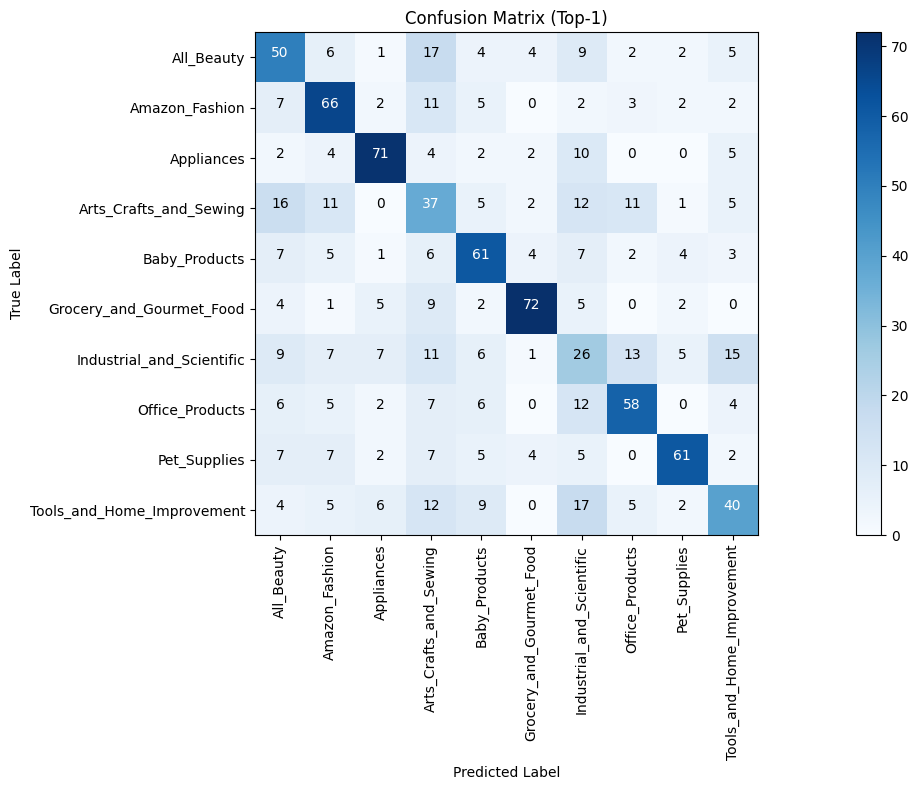

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(20, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Top-1)")
plt.colorbar()

classes = np.unique(y_true)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]}", ha="center", color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

In [26]:
y_res_df = pd.DataFrame()
y_res_df['true'] = y_true
y_res_df['pred'] = y_pred
y_res_df['true_pred_rank'] = y_true_pred_rank
y_res_df['pred_top3'] = y_res_df.apply(lambda x: x['true'] if x['true_pred_rank']<=3 else x['pred'],axis=1)
y_res_df['text'] = df_reviews.iloc[idx_test]['text'].values
print("Accuracy:", accuracy_score(y_res_df.true, y_res_df.pred_top3))
print("Classification Report:\n", classification_report(y_res_df.true,  y_res_df.pred_top3))

Accuracy: 0.763
Classification Report:
                             precision    recall  f1-score   support

                All_Beauty       0.71      0.72      0.71       100
            Amazon_Fashion       0.73      0.78      0.75       100
                Appliances       0.92      0.76      0.83       100
    Arts_Crafts_and_Sewing       0.64      0.88      0.74       100
             Baby_Products       0.74      0.76      0.75       100
  Grocery_and_Gourmet_Food       0.90      0.83      0.86       100
 Industrial_and_Scientific       0.65      0.78      0.71       100
           Office_Products       0.85      0.75      0.80       100
              Pet_Supplies       0.86      0.66      0.75       100
Tools_and_Home_Improvement       0.79      0.71      0.75       100

                  accuracy                           0.76      1000
                 macro avg       0.78      0.76      0.77      1000
              weighted avg       0.78      0.76      0.77      1000



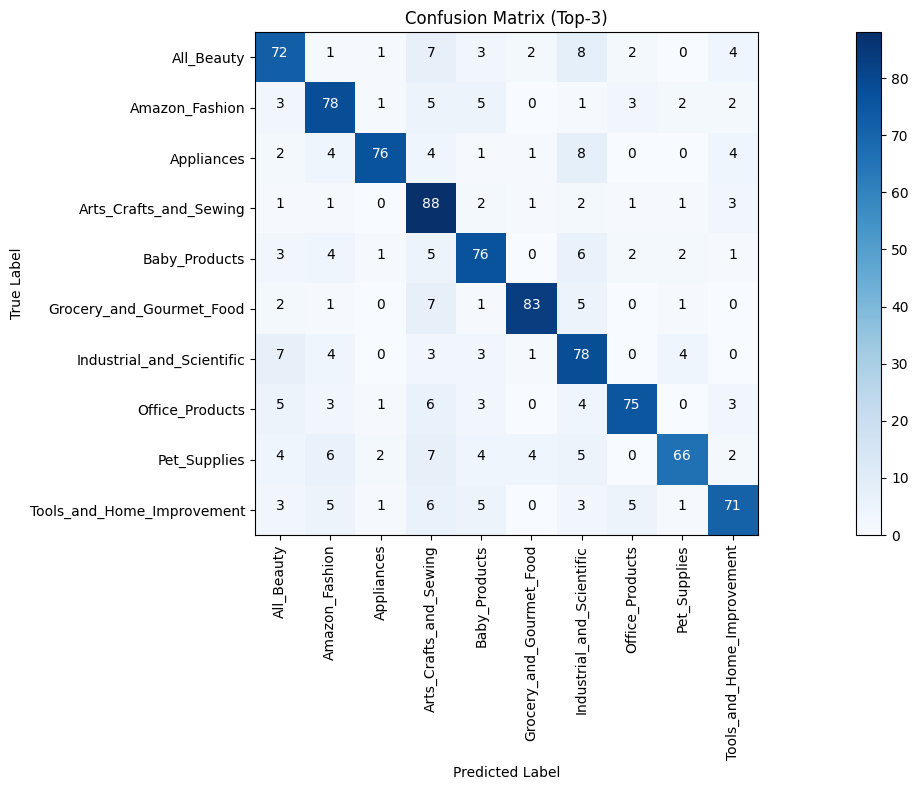

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_res_df.true,  y_res_df.pred_top3)

# Plot the confusion matrix
plt.figure(figsize=(20, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Top-3)")
plt.colorbar()

classes = np.unique(y_res_df.true)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]}", ha="center", color="white" if cm[i, j] > thresh else "black")

plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()

In [ ]:
Category,Features
All_Beauty,"['hair', 'skin', 'wig', 'shave', 'scent', 'brush', 'nail', 'shaver', 'face', 'eyebrow']"
Amazon_Fashion,"['dress', 'wear', 'shirt', 'fit', 'bra', 'chain', 'waist', 'outfit', 'size', 'to']"
Appliances,"['filter', 'coffee', 'ice', 'water', 'fridge', 'dryer', 'refrigerator', 'part', 'stove', 'cup']"
Arts_Crafts_and_Sewing,"['yarn', 'project', 'paint', 'bead', 'sewing', 'needle', 'color', 'mold', 'paper', 'backing']"
Baby_Products,"['baby', 'diaper', 'stroller', 'seat', 'pillow', 'son', 'wipe', 'monitor', 'diaper bag', 'strap']"
Grocery_and_Gourmet_Food,"['taste', 'flavor', 'tea', 'delicious', 'chocolate', 'sugar', 'sweet', 'taste like', 'stale', 'tasty']"
Industrial_and_Scientific,"['filament', 'nozzle', 'carpet', 'cleaner', 'unit', 'vacuum', 'test', 'pipe', 'print', '3d']"
Office_Products,"['printer', 'pen', 'ink', 'cartridge', 'page', 'pencil', 'phone', 'print', 'label', 'scan']"
Pet_Supplies,"['dog', 'cat', 'litter', 'food', 'pet', 'tank', 'dog love', 'collar', 'chew', 'cat not']"
Tools_and_Home_Improvement,"['light', 'bulb', 'faucet', 'bright', 'lamp', 'battery', 'knife', 'tool', 'led', 'of light']"